In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

## Aux functions

In [3]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Dataset Energy Appliances

In [28]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [34]:
from sklearn.model_selection import train_test_split
values = data.values
X = values
#(1, 19k, 26)
X = X.reshape((1,X.shape[0],X.shape[1]))
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

ValueError: With n_samples=1, test_size=0.1 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [31]:
X.shape

(1, 19735, 26)

In [32]:
X_train.shape

(14801, 26, 1)

In [9]:
# train_size=int(len(values) * 0.75)
    
# train_X, train_y = values[:train_size], values[:train_size]
# train_X, train_y = train_X[:, :-1], train_y[:, -1]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    
# test_X, test_y = values[train_size:], values[train_size:]
# test_X, test_y = test_X[:, :-1], test_y[:, -1]
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [10]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    #The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [13]:
IMG_SHAPE = X.shape[0:]
IMG_SHAPE

(19735, 26, 1)

In [18]:
X_train.shape 

(14801, 26, 1)

In [19]:
X_test.shape

(4934, 26, 1)

In [15]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[0:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 26)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 19735, 26, 1)]    0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 26)                13340886  
_________________________________________________________________
sequential_3 (Sequential)    (None, 19735, 26, 1)      13853970  
Total params: 27,194,856
Trainable params: 27,194,856
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
encoder.layers

In [26]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])

Epoch 1/20


ValueError: in user code:

    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/hugo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 19735, 26, 1), found shape=(None, 26, 1)


In [9]:
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

### Dataset Energy Appliances: columns

In [10]:
cols = data.columns
list_cols = list(cols)
list_cols.append('Appliances_t+1')
print(list_cols)

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Appliances_t+1']


### Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [11]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


In [12]:
data = pd.DataFrame(reframed.values,columns=list_cols)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances_t+1
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


### Model: AutoencoderWeightedMVFTS - AE-MVFTS

In [20]:
# No treinamento eu recebo os dados de treino completo, a variável alvo e a epocas
# Faço o treinamento do AE e a redução dos dados de treino.
# Crio o modelo WMVFTS e treino ele com os dados "encodificados (com dimensão reduzida)" 
def train_reducted(train, Y, input_layers, output_layers, epochs):
    
    input_layer = Input(shape=(input_layers, ))
    encoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder_layer_2 = Dense(2, activation="tanh")(encoder_layer_1)

    decoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(encoder_layer_2)
    decoder_layer_2 = Dense(input_layers, activation="tanh")(decoder_layer_1)

    autoencoder = Model(input_layer, decoder_layer_2)
    autoencoder.compile(optimizer = 'adam', loss='mse')
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)
    autoencoder.fit(x=X_train, y=X_train, epochs=epochs)

    encoder_model = Model(inputs=input_layer, outputs=encoder_layer_2)

    encoded_train = pd.DataFrame(encoder_model.predict(X_train))
    encoded_train.columns = ['factor_1', 'factor_2']
    encoded_train = encoded_train.join(Y)
    
    VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VY = variable.Variable("Appliances", data_label="Appliances_t+1", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 

    fts_model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VY], target_variable=VY)
    fts_model.fit(encoded_train)

    return fts_model, encoder_model, encoded_train


In [21]:
# No treino eu recebo o modelo WMVFTS treinado, o AE treinado, os dados te teste e a variável alvo
# Eu uso o AE treinado para reduzir a dimensão dos dados do treino
# Eu uso o WMVFTS treinado para fazer a previsão passando os dados de teste reduzidos
def forecast_reducted(fts_model, encoder_model,test, Y):
        
    scaler = MinMaxScaler()
    X_test = scaler.fit_transform(test)
    
    encoded_test = pd.DataFrame(encoder_model.predict(X_test))
    encoded_test.columns = ['factor_1', 'factor_2']
    encoded_test = encoded_test.join(Y)
    
    forecasts = fts_model.predict(encoded_test)

    return forecasts, encoded_test

## Sliding Window PyFTS: AE-WMVFTS

--------------------
training window 0
Epoch 1/50
16/16 [==============================] - 0s 540us/step - loss: 0.2565
Epoch 2/50
16/16 [==============================] - 0s 733us/step - loss: 0.2194
Epoch 3/50
16/16 [==============================] - 0s 754us/step - loss: 0.1787
Epoch 4/50
16/16 [==============================] - 0s 825us/step - loss: 0.1261
Epoch 5/50
16/16 [==============================] - 0s 946us/step - loss: 0.0891
Epoch 6/50
16/16 [==============================] - 0s 883us/step - loss: 0.0677
Epoch 7/50
16/16 [==============================] - 0s 965us/step - loss: 0.0565
Epoch 8/50
16/16 [==============================] - 0s 966us/step - loss: 0.0512
Epoch 9/50
16/16 [==============================] - 0s 893us/step - loss: 0.0476
Epoch 10/50
16/16 [==============================] - 0s 927us/step - loss: 0.0466
Epoch 11/50
16/16 [==============================] - 0s 905us/step - loss: 0.0453
Epoch 12/50
16/16 [==============================] - 0s 811us/step -

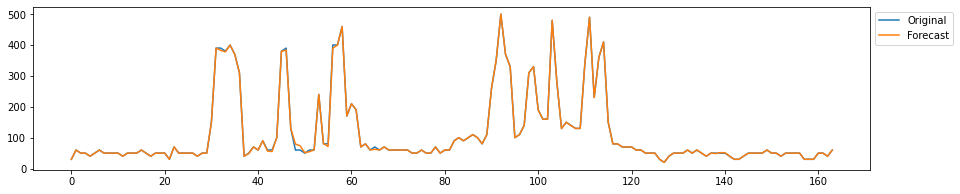

--------------------
training window 657
Epoch 1/50
16/16 [==============================] - 0s 554us/step - loss: 0.2650
Epoch 2/50
16/16 [==============================] - 0s 584us/step - loss: 0.1995
Epoch 3/50
16/16 [==============================] - 0s 708us/step - loss: 0.1527
Epoch 4/50
16/16 [==============================] - 0s 586us/step - loss: 0.1177
Epoch 5/50
16/16 [==============================] - 0s 616us/step - loss: 0.0898
Epoch 6/50
16/16 [==============================] - 0s 698us/step - loss: 0.0708
Epoch 7/50
16/16 [==============================] - 0s 612us/step - loss: 0.0594
Epoch 8/50
16/16 [==============================] - 0s 600us/step - loss: 0.0511
Epoch 9/50
16/16 [==============================] - 0s 777us/step - loss: 0.0462
Epoch 10/50
16/16 [==============================] - 0s 771us/step - loss: 0.0428
Epoch 11/50
16/16 [==============================] - 0s 723us/step - loss: 0.0400
Epoch 12/50
16/16 [==============================] - 0s 664us/step

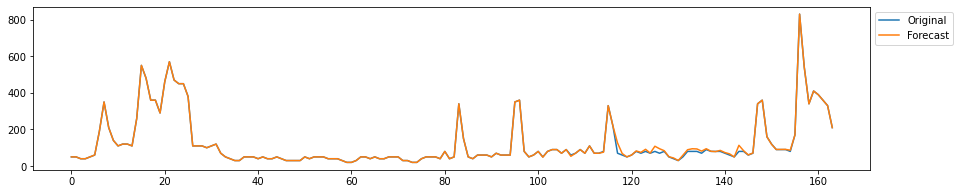

--------------------
training window 1314
Epoch 1/50
16/16 [==============================] - 0s 618us/step - loss: 0.3259
Epoch 2/50
16/16 [==============================] - 0s 783us/step - loss: 0.2658
Epoch 3/50
16/16 [==============================] - 0s 690us/step - loss: 0.2327
Epoch 4/50
16/16 [==============================] - 0s 591us/step - loss: 0.1866
Epoch 5/50
16/16 [==============================] - 0s 684us/step - loss: 0.1379
Epoch 6/50
16/16 [==============================] - 0s 817us/step - loss: 0.0995
Epoch 7/50
16/16 [==============================] - 0s 843us/step - loss: 0.0774
Epoch 8/50
16/16 [==============================] - 0s 825us/step - loss: 0.0676
Epoch 9/50
16/16 [==============================] - 0s 840us/step - loss: 0.0632
Epoch 10/50
16/16 [==============================] - 0s 888us/step - loss: 0.0584
Epoch 11/50
16/16 [==============================] - 0s 777us/step - loss: 0.0598
Epoch 12/50
16/16 [==============================] - 0s 718us/ste

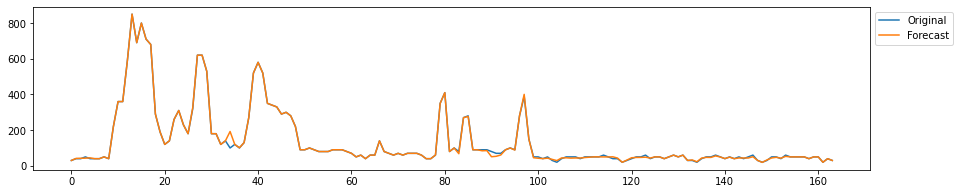

--------------------
training window 1971
Epoch 1/50
16/16 [==============================] - 0s 690us/step - loss: 0.3295
Epoch 2/50
16/16 [==============================] - 0s 554us/step - loss: 0.2388
Epoch 3/50
16/16 [==============================] - 0s 743us/step - loss: 0.1735
Epoch 4/50
16/16 [==============================] - 0s 726us/step - loss: 0.1209
Epoch 5/50
16/16 [==============================] - 0s 553us/step - loss: 0.0886
Epoch 6/50
16/16 [==============================] - 0s 683us/step - loss: 0.0673
Epoch 7/50
16/16 [==============================] - 0s 783us/step - loss: 0.0581
Epoch 8/50
16/16 [==============================] - 0s 800us/step - loss: 0.0542
Epoch 9/50
16/16 [==============================] - 0s 635us/step - loss: 0.0509
Epoch 10/50
16/16 [==============================] - 0s 621us/step - loss: 0.0497
Epoch 11/50
16/16 [==============================] - 0s 832us/step - loss: 0.0483
Epoch 12/50
16/16 [==============================] - 0s 822us/ste

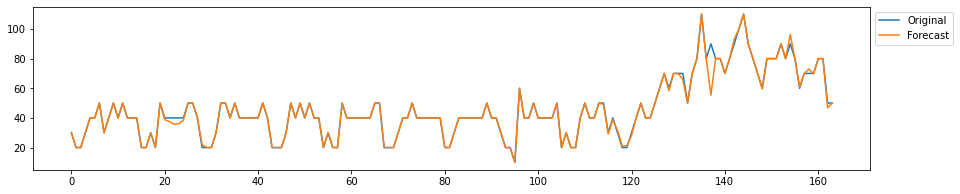

--------------------
training window 2628
Epoch 1/50
16/16 [==============================] - 0s 609us/step - loss: 0.5123
Epoch 2/50
16/16 [==============================] - 0s 796us/step - loss: 0.2647
Epoch 3/50
16/16 [==============================] - 0s 735us/step - loss: 0.2189
Epoch 4/50
16/16 [==============================] - 0s 613us/step - loss: 0.1712
Epoch 5/50
16/16 [==============================] - 0s 728us/step - loss: 0.1308
Epoch 6/50
16/16 [==============================] - 0s 781us/step - loss: 0.1093
Epoch 7/50
16/16 [==============================] - 0s 832us/step - loss: 0.0943
Epoch 8/50
16/16 [==============================] - 0s 877us/step - loss: 0.0796
Epoch 9/50
16/16 [==============================] - 0s 885us/step - loss: 0.0739
Epoch 10/50
16/16 [==============================] - 0s 799us/step - loss: 0.0685
Epoch 11/50
16/16 [==============================] - 0s 781us/step - loss: 0.0657
Epoch 12/50
16/16 [==============================] - 0s 722us/ste

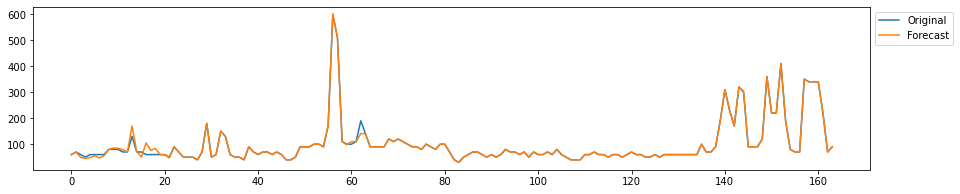

--------------------
training window 3285
Epoch 1/50
16/16 [==============================] - 0s 601us/step - loss: 0.3215
Epoch 2/50
16/16 [==============================] - 0s 715us/step - loss: 0.2708
Epoch 3/50
16/16 [==============================] - 0s 706us/step - loss: 0.2339
Epoch 4/50
16/16 [==============================] - 0s 577us/step - loss: 0.1806
Epoch 5/50
16/16 [==============================] - 0s 586us/step - loss: 0.1340
Epoch 6/50
16/16 [==============================] - 0s 765us/step - loss: 0.0944
Epoch 7/50
16/16 [==============================] - 0s 715us/step - loss: 0.0733
Epoch 8/50
16/16 [==============================] - 0s 613us/step - loss: 0.0608
Epoch 9/50
16/16 [==============================] - 0s 712us/step - loss: 0.0558
Epoch 10/50
16/16 [==============================] - 0s 795us/step - loss: 0.0524
Epoch 11/50
16/16 [==============================] - 0s 769us/step - loss: 0.0511
Epoch 12/50
16/16 [==============================] - 0s 729us/ste

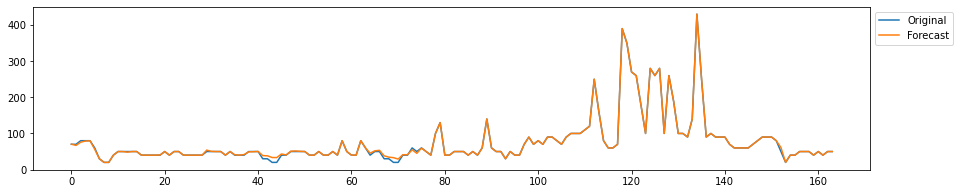

--------------------
training window 3942
Epoch 1/50
16/16 [==============================] - 0s 576us/step - loss: 0.2596
Epoch 2/50
16/16 [==============================] - 0s 512us/step - loss: 0.2094
Epoch 3/50
16/16 [==============================] - 0s 669us/step - loss: 0.1672
Epoch 4/50
16/16 [==============================] - 0s 686us/step - loss: 0.1358
Epoch 5/50
16/16 [==============================] - 0s 588us/step - loss: 0.1107
Epoch 6/50
16/16 [==============================] - 0s 627us/step - loss: 0.0901
Epoch 7/50
16/16 [==============================] - 0s 767us/step - loss: 0.0755
Epoch 8/50
16/16 [==============================] - 0s 693us/step - loss: 0.0648
Epoch 9/50
16/16 [==============================] - 0s 555us/step - loss: 0.0613
Epoch 10/50
16/16 [==============================] - 0s 713us/step - loss: 0.0555
Epoch 11/50
16/16 [==============================] - 0s 759us/step - loss: 0.0536
Epoch 12/50
16/16 [==============================] - 0s 736us/ste

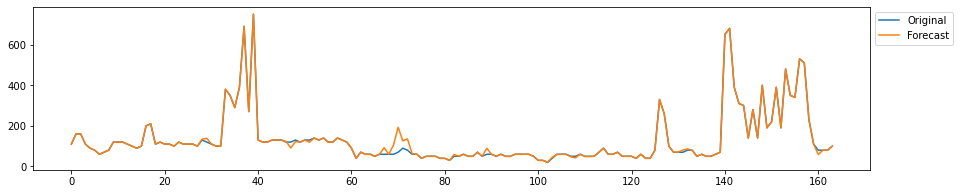

--------------------
training window 4599
Epoch 1/50
16/16 [==============================] - 0s 601us/step - loss: 0.2925
Epoch 2/50
16/16 [==============================] - 0s 544us/step - loss: 0.2372
Epoch 3/50
16/16 [==============================] - 0s 713us/step - loss: 0.1927
Epoch 4/50
16/16 [==============================] - 0s 668us/step - loss: 0.1553
Epoch 5/50
16/16 [==============================] - 0s 562us/step - loss: 0.1247
Epoch 6/50
16/16 [==============================] - 0s 709us/step - loss: 0.1025
Epoch 7/50
16/16 [==============================] - 0s 730us/step - loss: 0.0844
Epoch 8/50
16/16 [==============================] - 0s 752us/step - loss: 0.0748
Epoch 9/50
16/16 [==============================] - 0s 639us/step - loss: 0.0664
Epoch 10/50
16/16 [==============================] - 0s 715us/step - loss: 0.0600
Epoch 11/50
16/16 [==============================] - 0s 861us/step - loss: 0.0565
Epoch 12/50
16/16 [==============================] - 0s 771us/ste

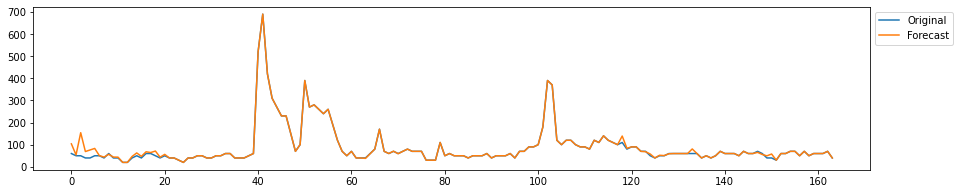

--------------------
training window 5256
Epoch 1/50
16/16 [==============================] - 0s 628us/step - loss: 0.2023
Epoch 2/50
16/16 [==============================] - 0s 673us/step - loss: 0.1638
Epoch 3/50
16/16 [==============================] - 0s 530us/step - loss: 0.1212
Epoch 4/50
16/16 [==============================] - 0s 703us/step - loss: 0.0947
Epoch 5/50
16/16 [==============================] - 0s 711us/step - loss: 0.0739
Epoch 6/50
16/16 [==============================] - 0s 635us/step - loss: 0.0604
Epoch 7/50
16/16 [==============================] - 0s 597us/step - loss: 0.0560
Epoch 8/50
16/16 [==============================] - 0s 757us/step - loss: 0.0512
Epoch 9/50
16/16 [==============================] - 0s 796us/step - loss: 0.0512
Epoch 10/50
16/16 [==============================] - 0s 696us/step - loss: 0.0461
Epoch 11/50
16/16 [==============================] - 0s 638us/step - loss: 0.0480
Epoch 12/50
16/16 [==============================] - 0s 725us/ste

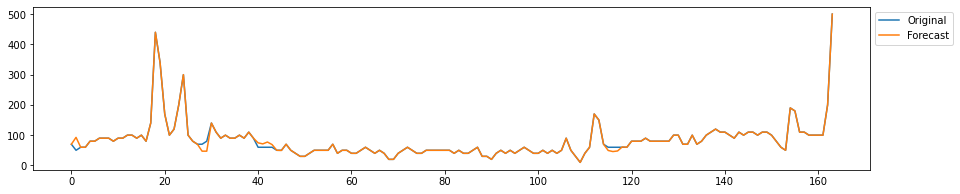

--------------------
training window 5913
Epoch 1/50
16/16 [==============================] - 0s 596us/step - loss: 0.2971
Epoch 2/50
16/16 [==============================] - 0s 585us/step - loss: 0.2620
Epoch 3/50
16/16 [==============================] - 0s 664us/step - loss: 0.2081
Epoch 4/50
16/16 [==============================] - 0s 562us/step - loss: 0.1670
Epoch 5/50
16/16 [==============================] - 0s 614us/step - loss: 0.1135
Epoch 6/50
16/16 [==============================] - 0s 746us/step - loss: 0.0862
Epoch 7/50
16/16 [==============================] - 0s 688us/step - loss: 0.0659
Epoch 8/50
16/16 [==============================] - 0s 573us/step - loss: 0.0580
Epoch 9/50
16/16 [==============================] - 0s 721us/step - loss: 0.0528
Epoch 10/50
16/16 [==============================] - 0s 755us/step - loss: 0.0508
Epoch 11/50
16/16 [==============================] - 0s 738us/step - loss: 0.0481
Epoch 12/50
16/16 [==============================] - 0s 586us/ste

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


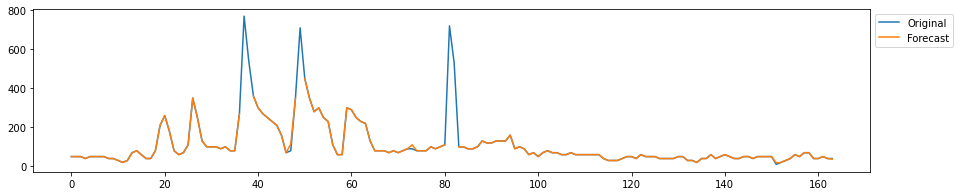

--------------------
training window 6570
Epoch 1/50
16/16 [==============================] - 0s 606us/step - loss: 0.3053
Epoch 2/50
16/16 [==============================] - 0s 659us/step - loss: 0.2215
Epoch 3/50
16/16 [==============================] - 0s 561us/step - loss: 0.1995
Epoch 4/50
16/16 [==============================] - 0s 721us/step - loss: 0.1669
Epoch 5/50
16/16 [==============================] - 0s 686us/step - loss: 0.1341
Epoch 6/50
16/16 [==============================] - 0s 558us/step - loss: 0.1040
Epoch 7/50
16/16 [==============================] - 0s 732us/step - loss: 0.0800
Epoch 8/50
16/16 [==============================] - 0s 804us/step - loss: 0.0644
Epoch 9/50
16/16 [==============================] - 0s 791us/step - loss: 0.0591
Epoch 10/50
16/16 [==============================] - 0s 652us/step - loss: 0.0555
Epoch 11/50
16/16 [==============================] - 0s 627us/step - loss: 0.0561
Epoch 12/50
16/16 [==============================] - 0s 747us/ste

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


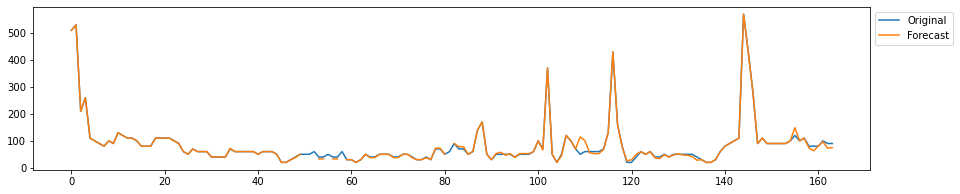

--------------------
training window 7227
Epoch 1/50
16/16 [==============================] - 0s 565us/step - loss: 0.3320
Epoch 2/50
16/16 [==============================] - 0s 526us/step - loss: 0.2279
Epoch 3/50
16/16 [==============================] - 0s 532us/step - loss: 0.2024
Epoch 4/50
16/16 [==============================] - 0s 964us/step - loss: 0.1723
Epoch 5/50
16/16 [==============================] - 0s 686us/step - loss: 0.1476
Epoch 6/50
16/16 [==============================] - 0s 571us/step - loss: 0.1167
Epoch 7/50
16/16 [==============================] - 0s 701us/step - loss: 0.0956
Epoch 8/50
16/16 [==============================] - 0s 727us/step - loss: 0.0806
Epoch 9/50
16/16 [==============================] - 0s 600us/step - loss: 0.0691
Epoch 10/50
16/16 [==============================] - 0s 597us/step - loss: 0.0619
Epoch 11/50
16/16 [==============================] - 0s 736us/step - loss: 0.0579
Epoch 12/50
16/16 [==============================] - 0s 742us/ste

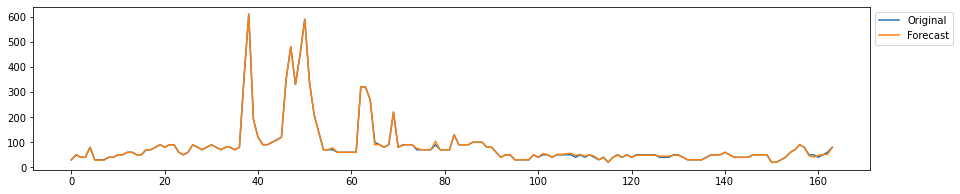

--------------------
training window 7884
Epoch 1/50
16/16 [==============================] - 0s 637us/step - loss: 0.2506
Epoch 2/50
16/16 [==============================] - 0s 626us/step - loss: 0.2135
Epoch 3/50
16/16 [==============================] - 0s 701us/step - loss: 0.1833
Epoch 4/50
16/16 [==============================] - 0s 554us/step - loss: 0.1478
Epoch 5/50
16/16 [==============================] - 0s 579us/step - loss: 0.1151
Epoch 6/50
16/16 [==============================] - 0s 700us/step - loss: 0.0911
Epoch 7/50
16/16 [==============================] - 0s 701us/step - loss: 0.0738
Epoch 8/50
16/16 [==============================] - 0s 601us/step - loss: 0.0628
Epoch 9/50
16/16 [==============================] - 0s 722us/step - loss: 0.0560
Epoch 10/50
16/16 [==============================] - 0s 800us/step - loss: 0.0535
Epoch 11/50
16/16 [==============================] - 0s 805us/step - loss: 0.0522
Epoch 12/50
16/16 [==============================] - 0s 790us/ste

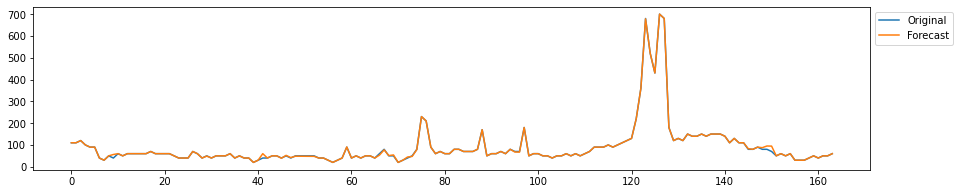

--------------------
training window 8541
Epoch 1/50
16/16 [==============================] - 0s 619us/step - loss: 0.2904
Epoch 2/50
16/16 [==============================] - 0s 680us/step - loss: 0.2448
Epoch 3/50
16/16 [==============================] - 0s 541us/step - loss: 0.2038
Epoch 4/50
16/16 [==============================] - 0s 683us/step - loss: 0.1568
Epoch 5/50
16/16 [==============================] - 0s 694us/step - loss: 0.1223
Epoch 6/50
16/16 [==============================] - 0s 573us/step - loss: 0.0957
Epoch 7/50
16/16 [==============================] - 0s 707us/step - loss: 0.0786
Epoch 8/50
16/16 [==============================] - 0s 754us/step - loss: 0.0689
Epoch 9/50
16/16 [==============================] - 0s 698us/step - loss: 0.0644
Epoch 10/50
16/16 [==============================] - 0s 589us/step - loss: 0.0617
Epoch 11/50
16/16 [==============================] - 0s 744us/step - loss: 0.0598
Epoch 12/50
16/16 [==============================] - 0s 798us/ste

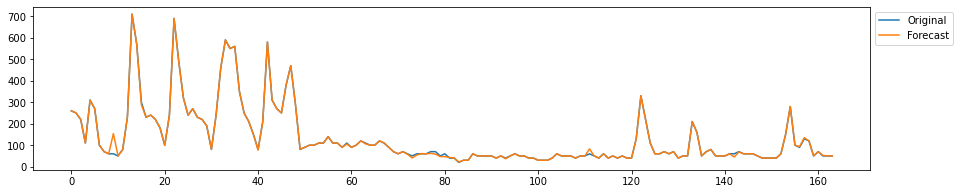

--------------------
training window 9198
Epoch 1/50
16/16 [==============================] - 0s 613us/step - loss: 0.2409
Epoch 2/50
16/16 [==============================] - 0s 590us/step - loss: 0.1870
Epoch 3/50
16/16 [==============================] - 0s 635us/step - loss: 0.1410
Epoch 4/50
16/16 [==============================] - 0s 544us/step - loss: 0.1118
Epoch 5/50
16/16 [==============================] - 0s 685us/step - loss: 0.0888
Epoch 6/50
16/16 [==============================] - 0s 670us/step - loss: 0.0751
Epoch 7/50
16/16 [==============================] - 0s 602us/step - loss: 0.0685
Epoch 8/50
16/16 [==============================] - 0s 694us/step - loss: 0.0661
Epoch 9/50
16/16 [==============================] - 0s 810us/step - loss: 0.0615
Epoch 10/50
16/16 [==============================] - 0s 752us/step - loss: 0.0608
Epoch 11/50
16/16 [==============================] - 0s 653us/step - loss: 0.0604
Epoch 12/50
16/16 [==============================] - 0s 827us/ste

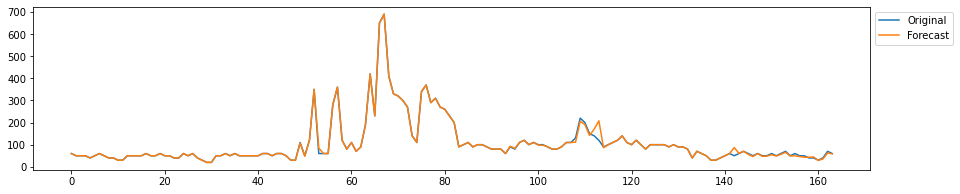

--------------------
training window 9855
Epoch 1/50
16/16 [==============================] - 0s 704us/step - loss: 0.2475
Epoch 2/50
16/16 [==============================] - 0s 574us/step - loss: 0.1968
Epoch 3/50
16/16 [==============================] - 0s 585us/step - loss: 0.1582
Epoch 4/50
16/16 [==============================] - 0s 777us/step - loss: 0.1245
Epoch 5/50
16/16 [==============================] - 0s 825us/step - loss: 0.1007
Epoch 6/50
16/16 [==============================] - 0s 740us/step - loss: 0.0832
Epoch 7/50
16/16 [==============================] - 0s 629us/step - loss: 0.0734
Epoch 8/50
16/16 [==============================] - 0s 684us/step - loss: 0.0661
Epoch 9/50
16/16 [==============================] - 0s 806us/step - loss: 0.0608
Epoch 10/50
16/16 [==============================] - 0s 845us/step - loss: 0.0591
Epoch 11/50
16/16 [==============================] - 0s 785us/step - loss: 0.0568
Epoch 12/50
16/16 [==============================] - 0s 697us/ste

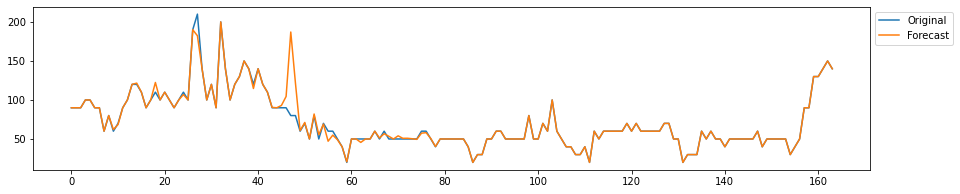

--------------------
training window 10512
Epoch 1/50
16/16 [==============================] - 0s 599us/step - loss: 0.3232
Epoch 2/50
16/16 [==============================] - 0s 579us/step - loss: 0.2408
Epoch 3/50
16/16 [==============================] - 0s 579us/step - loss: 0.2005
Epoch 4/50
16/16 [==============================] - 0s 561us/step - loss: 0.1616
Epoch 5/50
16/16 [==============================] - 0s 718us/step - loss: 0.1289
Epoch 6/50
16/16 [==============================] - 0s 686us/step - loss: 0.1018
Epoch 7/50
16/16 [==============================] - 0s 709us/step - loss: 0.0844
Epoch 8/50
16/16 [==============================] - 0s 611us/step - loss: 0.0710
Epoch 9/50
16/16 [==============================] - 0s 728us/step - loss: 0.0634
Epoch 10/50
16/16 [==============================] - 0s 726us/step - loss: 0.0582
Epoch 11/50
16/16 [==============================] - 0s 597us/step - loss: 0.0553
Epoch 12/50
16/16 [==============================] - 0s 638us/st

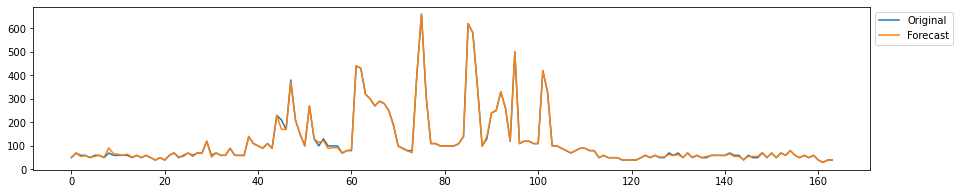

--------------------
training window 11169
Epoch 1/50
16/16 [==============================] - 0s 603us/step - loss: 0.2737
Epoch 2/50
16/16 [==============================] - 0s 511us/step - loss: 0.2217
Epoch 3/50
16/16 [==============================] - 0s 589us/step - loss: 0.1778
Epoch 4/50
16/16 [==============================] - 0s 710us/step - loss: 0.1376
Epoch 5/50
16/16 [==============================] - 0s 523us/step - loss: 0.1093
Epoch 6/50
16/16 [==============================] - 0s 719us/step - loss: 0.0830
Epoch 7/50
16/16 [==============================] - 0s 710us/step - loss: 0.0687
Epoch 8/50
16/16 [==============================] - 0s 602us/step - loss: 0.0615
Epoch 9/50
16/16 [==============================] - 0s 598us/step - loss: 0.0562
Epoch 10/50
16/16 [==============================] - 0s 742us/step - loss: 0.0524
Epoch 11/50
16/16 [==============================] - 0s 753us/step - loss: 0.0498
Epoch 12/50
16/16 [==============================] - 0s 640us/st

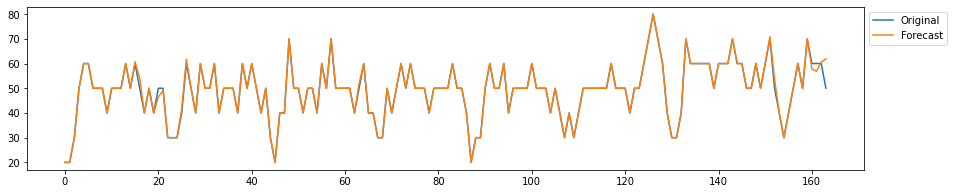

--------------------
training window 11826
Epoch 1/50
16/16 [==============================] - 0s 592us/step - loss: 0.2594
Epoch 2/50
16/16 [==============================] - 0s 710us/step - loss: 0.1928
Epoch 3/50
16/16 [==============================] - 0s 510us/step - loss: 0.1429
Epoch 4/50
16/16 [==============================] - 0s 681us/step - loss: 0.1118
Epoch 5/50
16/16 [==============================] - 0s 708us/step - loss: 0.0923
Epoch 6/50
16/16 [==============================] - 0s 554us/step - loss: 0.0801
Epoch 7/50
16/16 [==============================] - 0s 704us/step - loss: 0.0702
Epoch 8/50
16/16 [==============================] - 0s 716us/step - loss: 0.0635
Epoch 9/50
16/16 [==============================] - 0s 675us/step - loss: 0.0601
Epoch 10/50
16/16 [==============================] - 0s 588us/step - loss: 0.0562
Epoch 11/50
16/16 [==============================] - 0s 734us/step - loss: 0.0556
Epoch 12/50
16/16 [==============================] - 0s 814us/st

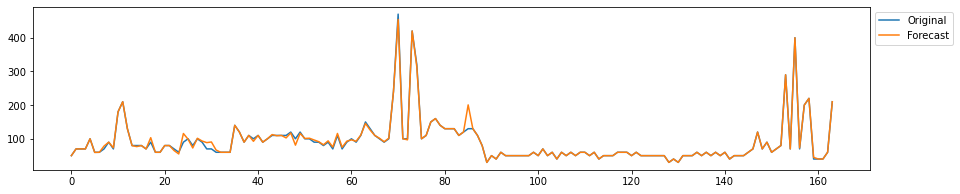

--------------------
training window 12483
Epoch 1/50
16/16 [==============================] - 0s 606us/step - loss: 0.2682
Epoch 2/50
16/16 [==============================] - 0s 567us/step - loss: 0.2151
Epoch 3/50
16/16 [==============================] - 0s 650us/step - loss: 0.1723
Epoch 4/50
16/16 [==============================] - 0s 551us/step - loss: 0.1245
Epoch 5/50
16/16 [==============================] - 0s 721us/step - loss: 0.0883
Epoch 6/50
16/16 [==============================] - 0s 742us/step - loss: 0.0689
Epoch 7/50
16/16 [==============================] - 0s 705us/step - loss: 0.0578
Epoch 8/50
16/16 [==============================] - 0s 608us/step - loss: 0.0537
Epoch 9/50
16/16 [==============================] - 0s 737us/step - loss: 0.0508
Epoch 10/50
16/16 [==============================] - 0s 798us/step - loss: 0.0506
Epoch 11/50
16/16 [==============================] - 0s 779us/step - loss: 0.0493
Epoch 12/50
16/16 [==============================] - 0s 668us/st

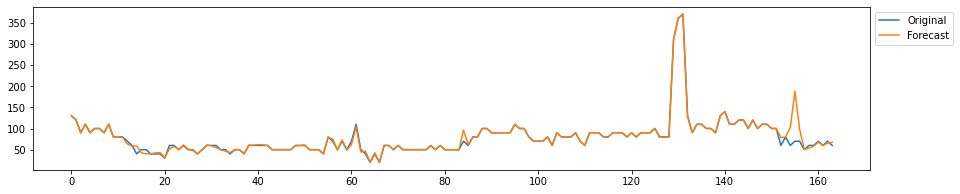

--------------------
training window 13140
Epoch 1/50
16/16 [==============================] - 0s 627us/step - loss: 0.2463
Epoch 2/50
16/16 [==============================] - 0s 570us/step - loss: 0.2042
Epoch 3/50
16/16 [==============================] - 0s 660us/step - loss: 0.1621
Epoch 4/50
16/16 [==============================] - 0s 547us/step - loss: 0.1207
Epoch 5/50
16/16 [==============================] - 0s 701us/step - loss: 0.0938
Epoch 6/50
16/16 [==============================] - 0s 739us/step - loss: 0.0731
Epoch 7/50
16/16 [==============================] - 0s 679us/step - loss: 0.0610
Epoch 8/50
16/16 [==============================] - 0s 600us/step - loss: 0.0538
Epoch 9/50
16/16 [==============================] - 0s 752us/step - loss: 0.0505
Epoch 10/50
16/16 [==============================] - 0s 833us/step - loss: 0.0472
Epoch 11/50
16/16 [==============================] - 0s 731us/step - loss: 0.0457
Epoch 12/50
16/16 [==============================] - 0s 661us/st

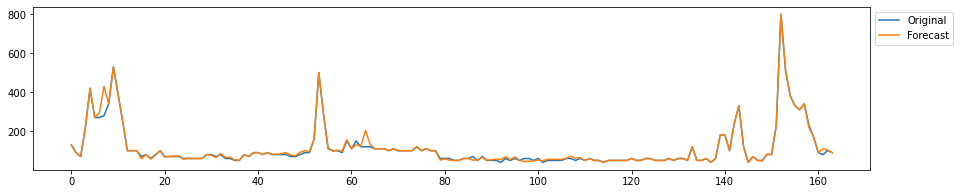

--------------------
training window 13797
Epoch 1/50
16/16 [==============================] - 0s 594us/step - loss: 0.2128
Epoch 2/50
16/16 [==============================] - 0s 699us/step - loss: 0.1707
Epoch 3/50
16/16 [==============================] - 0s 531us/step - loss: 0.1363
Epoch 4/50
16/16 [==============================] - 0s 734us/step - loss: 0.1079
Epoch 5/50
16/16 [==============================] - 0s 720us/step - loss: 0.0804
Epoch 6/50
16/16 [==============================] - 0s 574us/step - loss: 0.0648
Epoch 7/50
16/16 [==============================] - 0s 708us/step - loss: 0.0558
Epoch 8/50
16/16 [==============================] - 0s 744us/step - loss: 0.0527
Epoch 9/50
16/16 [==============================] - 0s 723us/step - loss: 0.0528
Epoch 10/50
16/16 [==============================] - 0s 626us/step - loss: 0.0523
Epoch 11/50
16/16 [==============================] - 0s 727us/step - loss: 0.0507
Epoch 12/50
16/16 [==============================] - 0s 771us/st

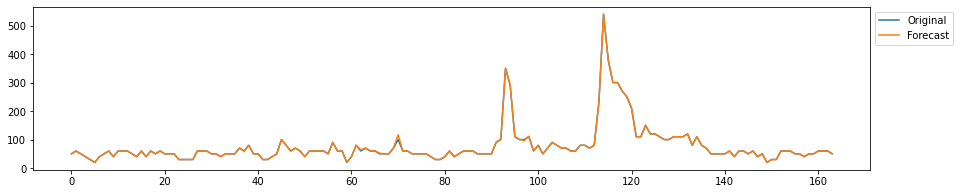

--------------------
training window 14454
Epoch 1/50
16/16 [==============================] - 0s 673us/step - loss: 0.2653
Epoch 2/50
16/16 [==============================] - 0s 597us/step - loss: 0.2155
Epoch 3/50
16/16 [==============================] - 0s 759us/step - loss: 0.1650
Epoch 4/50
16/16 [==============================] - 0s 753us/step - loss: 0.1272
Epoch 5/50
16/16 [==============================] - 0s 636us/step - loss: 0.1020
Epoch 6/50
16/16 [==============================] - 0s 684us/step - loss: 0.0822
Epoch 7/50
16/16 [==============================] - 0s 751us/step - loss: 0.0704
Epoch 8/50
16/16 [==============================] - 0s 781us/step - loss: 0.0635
Epoch 9/50
16/16 [==============================] - 0s 791us/step - loss: 0.0586
Epoch 10/50
16/16 [==============================] - 0s 661us/step - loss: 0.0545
Epoch 11/50
16/16 [==============================] - 0s 660us/step - loss: 0.0518
Epoch 12/50
16/16 [==============================] - 0s 770us/st

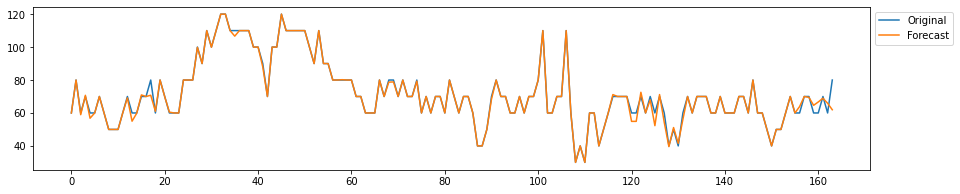

--------------------
training window 15111
Epoch 1/50
16/16 [==============================] - 0s 684us/step - loss: 0.2764
Epoch 2/50
16/16 [==============================] - 0s 788us/step - loss: 0.2271
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1828
Epoch 4/50
16/16 [==============================] - 0s 816us/step - loss: 0.1387
Epoch 5/50
16/16 [==============================] - 0s 872us/step - loss: 0.1048
Epoch 6/50
16/16 [==============================] - 0s 726us/step - loss: 0.0779
Epoch 7/50
16/16 [==============================] - 0s 747us/step - loss: 0.0631
Epoch 8/50
16/16 [==============================] - 0s 791us/step - loss: 0.0564
Epoch 9/50
16/16 [==============================] - 0s 776us/step - loss: 0.0539
Epoch 10/50
16/16 [==============================] - 0s 776us/step - loss: 0.0511
Epoch 11/50
16/16 [==============================] - 0s 661us/step - loss: 0.0506
Epoch 12/50
16/16 [==============================] - 0s 718us/step

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


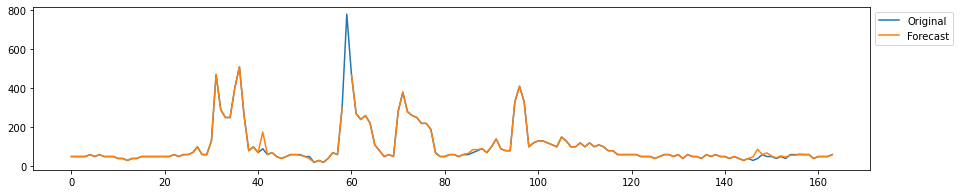

--------------------
training window 15768
Epoch 1/50
16/16 [==============================] - 0s 619us/step - loss: 0.2713
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2123
Epoch 3/50
16/16 [==============================] - 0s 537us/step - loss: 0.1689
Epoch 4/50
16/16 [==============================] - 0s 518us/step - loss: 0.1241
Epoch 5/50
16/16 [==============================] - 0s 514us/step - loss: 0.0908
Epoch 6/50
16/16 [==============================] - 0s 534us/step - loss: 0.0730
Epoch 7/50
16/16 [==============================] - 0s 499us/step - loss: 0.0620
Epoch 8/50
16/16 [==============================] - 0s 515us/step - loss: 0.0589
Epoch 9/50
16/16 [==============================] - 0s 501us/step - loss: 0.0565
Epoch 10/50
16/16 [==============================] - 0s 510us/step - loss: 0.0550
Epoch 11/50
16/16 [==============================] - 0s 490us/step - loss: 0.0546
Epoch 12/50
16/16 [==============================] - 0s 513us/step

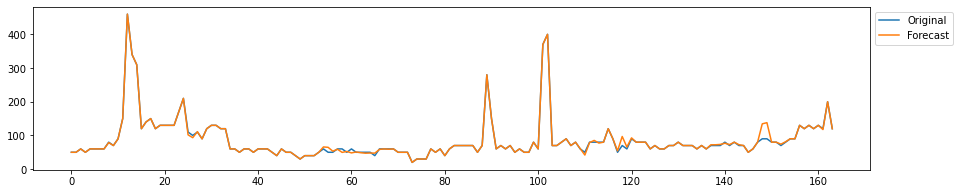

--------------------
training window 16425
Epoch 1/50
16/16 [==============================] - 0s 683us/step - loss: 0.3213
Epoch 2/50
16/16 [==============================] - 0s 802us/step - loss: 0.2797
Epoch 3/50
16/16 [==============================] - 0s 867us/step - loss: 0.2225
Epoch 4/50
16/16 [==============================] - 0s 913us/step - loss: 0.1675
Epoch 5/50
16/16 [==============================] - 0s 850us/step - loss: 0.1265
Epoch 6/50
16/16 [==============================] - 0s 669us/step - loss: 0.0987
Epoch 7/50
16/16 [==============================] - 0s 616us/step - loss: 0.0813
Epoch 8/50
16/16 [==============================] - 0s 621us/step - loss: 0.0726
Epoch 9/50
16/16 [==============================] - 0s 620us/step - loss: 0.0646
Epoch 10/50
16/16 [==============================] - 0s 693us/step - loss: 0.0627
Epoch 11/50
16/16 [==============================] - 0s 790us/step - loss: 0.0574
Epoch 12/50
16/16 [==============================] - 0s 613us/st

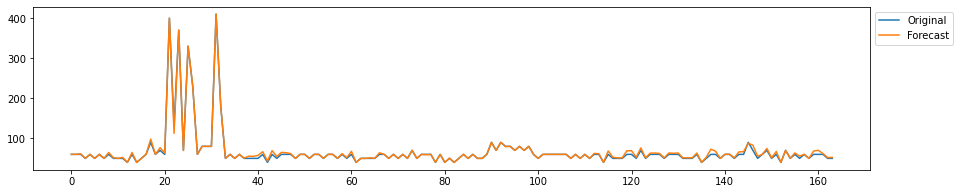

--------------------
training window 17082
Epoch 1/50
16/16 [==============================] - 0s 535us/step - loss: 0.2892
Epoch 2/50
16/16 [==============================] - 0s 523us/step - loss: 0.2405
Epoch 3/50
16/16 [==============================] - 0s 533us/step - loss: 0.1939
Epoch 4/50
16/16 [==============================] - 0s 521us/step - loss: 0.1506
Epoch 5/50
16/16 [==============================] - 0s 607us/step - loss: 0.1180
Epoch 6/50
16/16 [==============================] - 0s 511us/step - loss: 0.0894
Epoch 7/50
16/16 [==============================] - 0s 495us/step - loss: 0.0715
Epoch 8/50
16/16 [==============================] - 0s 500us/step - loss: 0.0584
Epoch 9/50
16/16 [==============================] - 0s 494us/step - loss: 0.0526
Epoch 10/50
16/16 [==============================] - 0s 492us/step - loss: 0.0467
Epoch 11/50
16/16 [==============================] - 0s 494us/step - loss: 0.0433
Epoch 12/50
16/16 [==============================] - 0s 508us/st

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


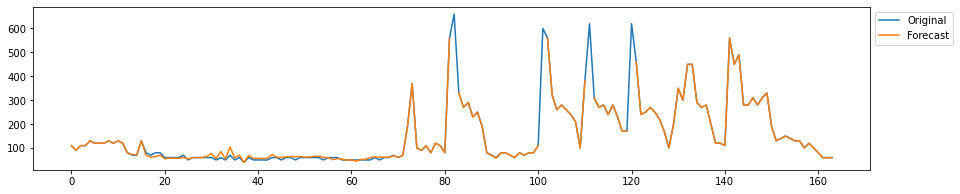

--------------------
training window 17739
Epoch 1/50
16/16 [==============================] - 0s 563us/step - loss: 0.2905
Epoch 2/50
16/16 [==============================] - 0s 543us/step - loss: 0.2355
Epoch 3/50
16/16 [==============================] - 0s 529us/step - loss: 0.1917
Epoch 4/50
16/16 [==============================] - 0s 548us/step - loss: 0.1575
Epoch 5/50
16/16 [==============================] - 0s 524us/step - loss: 0.1256
Epoch 6/50
16/16 [==============================] - 0s 633us/step - loss: 0.1005
Epoch 7/50
16/16 [==============================] - 0s 487us/step - loss: 0.0832
Epoch 8/50
16/16 [==============================] - 0s 674us/step - loss: 0.0722
Epoch 9/50
16/16 [==============================] - 0s 685us/step - loss: 0.0657
Epoch 10/50
16/16 [==============================] - 0s 596us/step - loss: 0.0604
Epoch 11/50
16/16 [==============================] - 0s 573us/step - loss: 0.0578
Epoch 12/50
16/16 [==============================] - 0s 577us/st

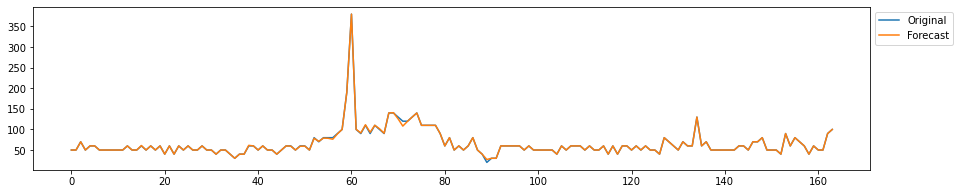

--------------------
training window 18396
Epoch 1/50
16/16 [==============================] - 0s 538us/step - loss: 0.3102
Epoch 2/50
16/16 [==============================] - 0s 486us/step - loss: 0.2383
Epoch 3/50
16/16 [==============================] - 0s 525us/step - loss: 0.2149
Epoch 4/50
16/16 [==============================] - 0s 494us/step - loss: 0.1769
Epoch 5/50
16/16 [==============================] - 0s 501us/step - loss: 0.1492
Epoch 6/50
16/16 [==============================] - 0s 504us/step - loss: 0.1140
Epoch 7/50
16/16 [==============================] - 0s 506us/step - loss: 0.0936
Epoch 8/50
16/16 [==============================] - 0s 483us/step - loss: 0.0803
Epoch 9/50
16/16 [==============================] - 0s 503us/step - loss: 0.0696
Epoch 10/50
16/16 [==============================] - 0s 511us/step - loss: 0.0630
Epoch 11/50
16/16 [==============================] - 0s 494us/step - loss: 0.0608
Epoch 12/50
16/16 [==============================] - 0s 521us/st

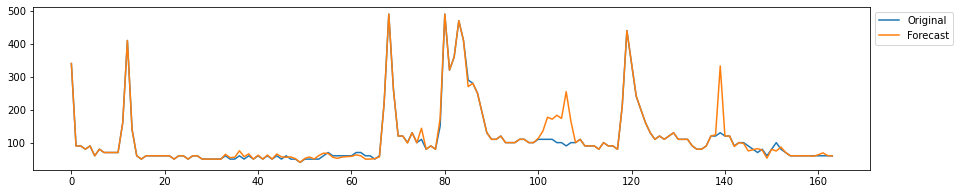

--------------------
training window 19053
Epoch 1/50
16/16 [==============================] - 0s 554us/step - loss: 0.3436
Epoch 2/50
16/16 [==============================] - 0s 538us/step - loss: 0.2590
Epoch 3/50
16/16 [==============================] - 0s 545us/step - loss: 0.2210
Epoch 4/50
16/16 [==============================] - 0s 521us/step - loss: 0.1774
Epoch 5/50
16/16 [==============================] - 0s 513us/step - loss: 0.1363
Epoch 6/50
16/16 [==============================] - 0s 485us/step - loss: 0.0991
Epoch 7/50
16/16 [==============================] - 0s 484us/step - loss: 0.0763
Epoch 8/50
16/16 [==============================] - 0s 487us/step - loss: 0.0631
Epoch 9/50
16/16 [==============================] - 0s 480us/step - loss: 0.0565
Epoch 10/50
16/16 [==============================] - 0s 472us/step - loss: 0.0539
Epoch 11/50
16/16 [==============================] - 0s 487us/step - loss: 0.0503
Epoch 12/50
16/16 [==============================] - 0s 454us/st

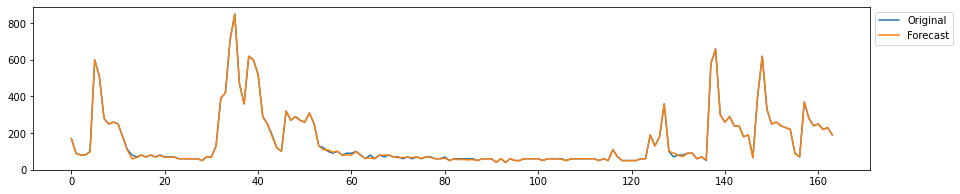

In [23]:
input_layers = 26
output_layers = 2 
epocs = 50

result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        appliance = ttest['Appliances_t+1'].reset_index()
        appliance_train = ttrain['Appliances_t+1'].reset_index()
        print('-' * 20)
        print(f'training window {(ct)}')
        # Faz o treinamento 
        fts_model, encoder_model, encoded_train = train_reducted(ttrain.loc[:,'Appliances':'Tdewpoint'], 
                                                                 appliance_train, input_layers,
                                                                 output_layers, epocs)
        # Faz o teste 
        forecast, encoded_test = forecast_reducted(fts_model, encoder_model,ttest.loc[:,'Appliances':'Tdewpoint'],
                                                   appliance)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        appliance.pop('index')
        rmse = Measures.rmse(encoded_test['Appliances_t+1'],forecast)
        mape = Measures.mape(encoded_test['Appliances_t+1'],forecast)
        smape = Measures.smape(encoded_test['Appliances_t+1'],forecast)
        
        #forecasts.append(forecast)
        #appliances.append(appliance)
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(encoded_test['Appliances_t+1'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()

measures = pd.DataFrame(result)



In [22]:
measures

,window,rmse,mape,smape
0,0,2.050605,0.374548,0.160967
1,657,6.705636,2.035954,0.955255
2,1314,0.556267,0.175035,0.088554
3,1971,1.474364,0.458929,0.227495
4,2628,2.900615,0.783316,0.389163
5,3285,2.775980,2.684445,1.337257
6,3942,13.067709,7.556787,3.166375
7,4599,11.242452,6.910878,2.891260
8,5256,3.722530,0.847226,0.356056
9,5913,9.320251,3.612240,1.499722


### Mean Statistics AE-WMVFTS

In [24]:
final_result = {
     "rmse": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics AE-WMVFTS (test): ")
final_measures_pca

Mean Statistics AE-WMVFTS (test): 


,rmse,mape,smape
0,6.471413,2.544033,1.124554
